In [392]:
import pandas as pd
import numpy as np
import datetime as datetime 
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 1.  Data Load & Understanding
###   1.1. Data Load

In [1142]:
pd.low_memory=False
RejectStats = pd.read_excel("Data_Dictionary.xlsx", sheet_name=1)
RejectStats.head(20)
loan_all = pd.read_csv("loan.csv")
loan_all.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [1143]:
loan_all.shape

(39717, 111)

In [1144]:
loan_all.info()

# observations :
#Data has 74  float value columns
#Data has 13  int64 value columns
#Data has 24  object/String value columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


###   1.2. Data Understanding

In [1146]:
### Getting a list of columns having nulls
loan_all.isnull().sum().value_counts()

# found that 54 columns have all null
# found that 2 columns in 56 rows are null
# Rest rows has very less nulls and 43 columns does not have any nulls


39717    54
0        43
56        2
2459      1
1075      1
12940     1
11        1
25682     1
36931     1
50        1
71        1
38577     1
2         1
697       1
39        1
dtype: int64

In [1147]:
### Getting a names of columns having all nulls
allnulls = loan_all.isnull().sum()
allnulls[allnulls==loan_all.shape[0]].index

Index(['mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dl

In [1148]:
### Getting the list of columns having more that 35% of missing / null values, 
### 35% is considered as threshold for missing values.
allnulls[allnulls>(loan_all.shape[0]*0.35)]

mths_since_last_delinq            25682
mths_since_last_record            36931
next_pymnt_d                      38577
mths_since_last_major_derog       39717
annual_inc_joint                  39717
dti_joint                         39717
verification_status_joint         39717
tot_coll_amt                      39717
tot_cur_bal                       39717
open_acc_6m                       39717
open_il_6m                        39717
open_il_12m                       39717
open_il_24m                       39717
mths_since_rcnt_il                39717
total_bal_il                      39717
il_util                           39717
open_rv_12m                       39717
open_rv_24m                       39717
max_bal_bc                        39717
all_util                          39717
total_rev_hi_lim                  39717
inq_fi                            39717
total_cu_tl                       39717
inq_last_12m                      39717
acc_open_past_24mths              39717


In [1149]:
### Getting a list of columns having not unique values
loan_all.nunique().sort_values(ascending=False)[:15]

# found that 3 columns having same/single value
# found that 2 columns has all unique value which are id and member_id 
# Rest rows has very less nulls


id                 39717
url                39717
member_id          39717
total_pymnt        37850
total_pymnt_inv    37518
total_rec_int      35148
last_pymnt_amnt    34930
emp_title          28820
desc               26527
revol_bal          21711
title              19615
installment        15383
funded_amnt_inv     8205
total_rec_prncp     7976
annual_inc          5318
dtype: int64

In [1150]:
### Getting a names of columns having all nulls
uniques = loan_all.nunique()
uniques[uniques==1].index

Index(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'],
      dtype='object')

In [1151]:
loan_all.shape

(39717, 111)

In [1152]:
# checking a list of rows having null in 10 or more columns
loan_dropna = loan_all.dropna(thresh=10)

In [1153]:
loan_dropna.shape
# understanding
# not found any rows having missing values in more than 9 columns

(39717, 111)

# 2.  Data Cleaning 
### 1. Removing columns with all nulls and non-unique value in all rows
* Checking the shape and checking nulls again

In [1154]:
### Getting a list of columns having all nulls more than 35% threshhold
allnulls = loan_all.isnull().sum()

### Getting a list of columns having unique values 
uniques = loan_all.nunique()

## Concatinating both list 
removeIndexes = np.concatenate((uniques[uniques==1].index.values, 
                               allnulls[allnulls>(loan_all.shape[0]*0.35)].index.values))

## Removing from Loan Data
loan_all = loan_all.drop(removeIndexes, axis=1)
loan_all.shape

# understanding 
# 45 columns left after removing nulls/missing columns more that 35% threshhold and Non-unique values.

(39717, 45)

In [1155]:
## checking columns having more nulls
loan_all.isnull().sum().sort_values(ascending=False)[:10]

desc                    12940
emp_title                2459
emp_length               1075
pub_rec_bankruptcies      697
last_pymnt_d               71
revol_util                 50
title                      11
last_credit_pull_d          2
out_prncp_inv               0
open_acc                    0
dtype: int64

In [1156]:
loan_all.emp_length.value_counts()

10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: emp_length, dtype: int64

In [1157]:
loan_all.emp_title.value_counts()

US Army                              134
Bank of America                      109
IBM                                   66
AT&T                                  59
Kaiser Permanente                     56
                                    ... 
Community College of Philadelphia      1
AMEC                                   1
lee county sheriff                     1
Bacon County Board of Education        1
Evergreen Center                       1
Name: emp_title, Length: 28820, dtype: int64

In [1158]:
loan_all[(loan_all["emp_title"].str.contains("student")) & (-loan_all["emp_title"].isnull())].emp_title.value_counts()

first student bus co.    1
first student            1
Name: emp_title, dtype: int64

In [1159]:
loan_all[loan_all["emp_title"].isnull()]["purpose"].value_counts()

debt_consolidation    830
small_business        354
credit_card           303
other                 287
home_improvement      218
major_purchase        148
car                    86
medical                47
moving                 41
vacation               39
wedding                35
house                  31
educational            26
renewable_energy       14
Name: purpose, dtype: int64

In [1160]:
loan_all[(loan_all["purpose"]=="small_business") & loan_all["emp_title"].isnull()][["purpose","emp_title"]]

,purpose,emp_title
2,small_business,NaN
8,small_business,NaN
61,small_business,NaN
110,small_business,NaN
270,small_business,NaN
...,...,...
39519,small_business,NaN
39547,small_business,NaN
39613,small_business,NaN
39640,small_business,NaN


In [1161]:
# Checking the data with object type
loan_all.select_dtypes(include=['object']).head()

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,url,desc,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,last_pymnt_d,last_credit_pull_d
0,36 months,10.65%,B,B2,NaN,10+ years,RENT,Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,Jan-85,83.70%,Jan-15,May-16
1,60 months,15.27%,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-11,Charged Off,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,Apr-99,9.40%,Apr-13,Sep-13
2,36 months,15.96%,C,C5,NaN,10+ years,RENT,Not Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,Nov-01,98.50%,Jun-14,May-16
3,36 months,13.49%,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,Feb-96,21%,Jan-15,Apr-16
4,60 months,12.69%,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-11,Current,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,Jan-96,53.90%,May-16,May-16


In [1162]:

# understading

# 1.  No use of the following columns so those should be removed.
# "url"
# "desc"
# "id"
# "member_id"
# "emp_title"
# "title"
# "zip_code" is having "xx" as last 2 digts, this data is incomleted/incorrect. So removing this column


# 2.  Renaming (for better clarity of column names) and converting year from "yy" to "yyyy" in date columns
#    "issue_d" - > "issue_date" and converting year from "yy" to "yyyy"
#    "earliest_cr_line" - > converting year from "yy" to "yyyy"
#    "last_pymnt_d" - > "last_pymnt_date" and converting year from "yy" to "yyyy"
#    "last_credit_pull_d" - > "last_credit_pull_date" and converting year from "yy" to "yyyy"


# 3.  "term" should be integer but having " months", so " months" should be removed from "term" and converrted to int.
# column name updated from "term" to "term_months" for better clarity

# 4.  "int_rate" is having "%", so "%" should be removed from "int_rate" and converrted to float
# "revol_util" is having "%", so "%" should be removed from "revol_util" and converrted to float

# 5.  "emp_length" is already segmented but "emp_length" has "years"/"year", so "years"/"year" should be removed

# 6.  "loan_status" is having currntly running loans with "Current" value. Currently running loan are not completed yet. 
# So it is unclear that they will default or not, so removing all rows with loan_status="Current" from this analysis.


### 1.  No use of the following columns so those should be removed.
* "url"
* "desc"
* "id"
* "member_id"
* "emp_title"
* "title"
* "zip_code" is having "xx" as last 2 digts, this data is incomleted/incorrect. So removing this column


In [1163]:
# Dropping other non-required columns
loan_all = loan_all.drop(columns=["url","desc","id","member_id","emp_title","title","zip_code"], axis=1)

### 2.  Renaming (for better clarity of column names) and converting year from "yy" to "yyyy" in date columns
*    "issue_d" - > "issue_date" and converting year from "yy" to "yyyy"
*    "earliest_cr_line" - > converting year from "yy" to "yyyy"
*    "last_pymnt_d" - > "last_pymnt_date" and converting year from "yy" to "yyyy"
*    "last_credit_pull_d" - > "last_credit_pull_date" and converting year from "yy" to "yyyy"

In [1164]:
def addCentury(x):
    if str(x)[-2:]=="an":
        return "No Date"
    else:
        return str(x)[:-2]+str(20)+str(x)[-2:] if int(str(x)[-2:])<22 else str(x)[:-2]+str(19)+str(x)[-2:]

loan_all["issue_d"] = loan_all["issue_d"].apply(addCentury)
loan_all["earliest_cr_line"] = loan_all["earliest_cr_line"].apply(addCentury)
loan_all["last_pymnt_d"] = loan_all["last_pymnt_d"].apply(addCentury)
loan_all["last_credit_pull_d"] = loan_all["last_credit_pull_d"].apply(addCentury)

loan_all.rename(columns={"issue_d":"issue_date","last_pymnt_d":"last_pymnt_date",
                         "last_credit_pull_d":"last_credit_pull_date"}, inplace=True)


### 3.  "term_months" should be integer but having " months", so " months" should be removed from "term_months" and converrted to int.
* column name updated from "term" to "term_months" for better clarity

In [1165]:
loan_all["term"] = loan_all["term"].apply(lambda x: int(x[0:3]))

loan_all.rename(columns={"term":"term_months"}, inplace=True)


### 4  "revol_util" is having "%", so "%" should be removed from "revol_util" and converrted to float
and "int_rate" is having "%", so "%" should be removed from "int_rate" and converrted to float

* column name updated from "revol_util" to "revol_util_percent" for better clarity

In [1166]:
# Uncomment all lines and Run Once only
def removePercent(x):
    return float(x[:-1]) if str(x)[-1]=="%" else x

loan_all["int_rate"] = loan_all["int_rate"].apply(removePercent)
loan_all["revol_util"] = loan_all["revol_util"].apply(removePercent)

loan_all.rename(columns={"revol_util":"revol_util_percent"}, inplace=True)

### 5.  "emp_length" is already segmented but "emp_length" has "years"/"year", so "years"/"year" should be removed

In [1167]:
# Replacing XX to blank in Zipcode
loan_all["emp_length"] = loan_all["emp_length"].apply(lambda x: str(x).replace("years","").replace("year",""))


### 6.  "loan_status" is having currntly running loans with "Current" value. Currently running loan are not completed yet. 
* So it is unclear that they will default or not, so removing all rows with loan_status="Current" from this analysis.


In [1168]:
## Extracting all "Current" loans to another list loan_curr and Removing from loan_all
loan_curr = loan_all[loan_all.loan_status=="Current"]
loan_all = loan_all[-(loan_all.loan_status=="Current")]

In [1169]:
# checking all object types columns
loan_all.select_dtypes(include=['object']).head(10)

,grade,sub_grade,emp_length,home_ownership,verification_status,issue_date,loan_status,purpose,addr_state,earliest_cr_line,last_pymnt_date,last_credit_pull_date
0,B,B2,10+,RENT,Verified,Dec-2011,Fully Paid,credit_card,AZ,Jan-1985,Jan-2015,May-2016
1,C,C4,< 1,RENT,Source Verified,Dec-2011,Charged Off,car,GA,Apr-1999,Apr-2013,Sep-2013
2,C,C5,10+,RENT,Not Verified,Dec-2011,Fully Paid,small_business,IL,Nov-2001,Jun-2014,May-2016
3,C,C1,10+,RENT,Source Verified,Dec-2011,Fully Paid,other,CA,Feb-1996,Jan-2015,Apr-2016
5,A,A4,3,RENT,Source Verified,Dec-2011,Fully Paid,wedding,AZ,Nov-2004,Jan-2015,Jan-2016
6,C,C5,8,RENT,Not Verified,Dec-2011,Fully Paid,debt_consolidation,NC,Jul-2005,May-2016,May-2016
7,E,E1,9,RENT,Source Verified,Dec-2011,Fully Paid,car,CA,Jan-2007,Jan-2015,Dec-2014
8,F,F2,4,OWN,Source Verified,Dec-2011,Charged Off,small_business,CA,Apr-2004,Apr-2012,Aug-2012
9,B,B5,< 1,RENT,Verified,Dec-2011,Charged Off,other,TX,Sep-2004,Nov-2012,Mar-2013
10,C,C3,5,OWN,Not Verified,Dec-2011,Fully Paid,debt_consolidation,AZ,Jan-1998,Jun-2013,Dec-2015


In [1170]:
loan_all.select_dtypes(include=['int']).head()

,loan_amnt,funded_amnt,term_months,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc
0,5000,5000,36,0,1,3,0,13648,9
1,2500,2500,60,0,5,3,0,1687,4
2,2400,2400,36,0,2,2,0,2956,10
3,10000,10000,36,0,1,10,0,5598,37
5,5000,5000,36,0,3,9,0,7963,12


In [1171]:
loan_all.select_dtypes(include=['float']).head()

,funded_amnt_inv,int_rate,installment,annual_inc,dti,revol_util_percent,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies
0,4975.0,10.65,162.87,24000.0,27.65,83.7,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,171.62,0.0
1,2500.0,15.27,59.83,30000.0,1.00,9.4,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0
2,2400.0,15.96,84.33,12252.0,8.72,98.5,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,649.91,0.0
3,10000.0,13.49,339.31,49200.0,20.00,21.0,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,357.48,0.0
5,5000.0,7.90,156.46,36000.0,11.20,28.3,0.0,0.0,5632.210000,5632.21,5000.00,632.21,0.00,0.00,0.00,161.03,0.0


# 3.  Derived Columns
### 1. Extracting  "issue_month" and  "issue_year" from  "issue_date"

In [1172]:
loan_all["issue_month"]=pd.DatetimeIndex(loan_all.issue_date).month
loan_all["issue_year"]=pd.DatetimeIndex(loan_all.issue_date).year

### 2. Make segments of int_rate.

In [1192]:
loan_all.int_rate.describe()

count    36815.000000
mean        11.889882
std          3.668709
min          5.420000
25%          8.940000
50%         11.710000
75%         14.270000
max         24.400000
Name: int_rate, dtype: float64

In [1173]:
loan_all.int_rate.describe()
# Since min int_rate is 5.42 and max >24.4 making 5 segments from 5 to 25.

count    38577.000000
mean        11.932219
std          3.691327
min          5.420000
25%          8.940000
50%         11.710000
75%         14.380000
max         24.400000
Name: int_rate, dtype: float64

In [1174]:
def makeRateGroups(x):
    if x<10:
        return "0-10"
    elif x<13:
        return "10-13"
    elif x<16:
        return "13-16"
    elif x<19:
        return "16-19"
    elif x>=19:
        return ">19"

# Make groups of int_rate.
loan_all['int_rate_category'] = loan_all.int_rate.apply(makeRateGroups)
loan_all['int_rate_category'].value_counts()

0-10     12067
10-13    11931
13-16     9076
16-19     4103
>19       1400
Name: int_rate_category, dtype: int64

### 3. Make segments of dti.

In [1175]:
# Using the same segments used in "int_rate" for "dti"
loan_all['dti_category'] = loan_all.dti.apply(makeRateGroups)
loan_all['dti_category'].value_counts()

0-10     12905
>19       8899
13-16     5860
10-13     5666
16-19     5247
Name: dti_category, dtype: int64

### 4. Make segments of Amount.

In [1176]:
loan_all.loan_amnt.describe()
# Since min int_rate is 500 and max 35000 making 5 segments from 500 to 35000.

count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [1197]:

# Calculating IQR for annual_inc
q1 = loan_all.loan_amnt.quantile(0.25)
q3 = loan_all.loan_amnt.quantile(0.75)
iqr = q3-q1
print(q1)
print(q3)
print(iqr)
# loan_all = loan_all[-(loan_all.loan_amnt>((iqr*1.5)+q3))]
# loan_all = loan_all[-(loan_all.loan_amnt<(q1-(iqr*1.5)))]


5000.0
15000.0
10000.0


,loan_amnt,funded_amnt,funded_amnt_inv,term_months,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,last_pymnt_date,last_pymnt_amnt,last_credit_pull_date,pub_rec_bankruptcies,issue_month,issue_year,int_rate_category,dti_category,loan_amnt_category,annual_inc_category
31,31825,31825,31825.00000,36,7.90,995.82,A,A4,5,MORTGAGE,...,Aug-2013,16966.70,Feb-2016,0.0,12,2011,0-10,13-16,>25000,75000-100000
128,35000,35000,35000.00000,36,8.90,1111.37,A,A5,6,MORTGAGE,...,Jan-2015,1123.85,Mar-2016,0.0,12,2011,0-10,>19,>25000,>125000
268,35000,26825,26800.00000,60,18.64,690.56,E,E1,8,MORTGAGE,...,Mar-2012,26684.35,May-2016,0.0,12,2011,16-19,10-13,>25000,75000-100000
276,35000,35000,35000.00000,36,8.90,1111.37,A,A5,5,RENT,...,Oct-2012,27308.49,Oct-2012,0.0,12,2011,0-10,16-19,>25000,75000-100000
306,35000,23250,23200.00000,60,20.30,619.88,E,E5,5,RENT,...,Oct-2015,8847.24,May-2016,0.0,12,2011,>19,>19,>25000,75000-100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19604,35000,35000,34950.00000,60,16.40,858.59,E,E1,< 1,OWN,...,Mar-2011,35479.89,Mar-2011,0.0,2,2011,16-19,10-13,>25000,75000-100000
19740,35000,35000,31845.22117,60,18.99,907.73,F,F3,10+,RENT,...,Sep-2013,21923.25,Oct-2013,0.0,2,2011,16-19,10-13,>25000,>125000
19760,33000,33000,29044.28153,60,16.77,816.06,E,E2,nan,MORTGAGE,...,Feb-2016,816.01,Feb-2016,0.0,2,2011,16-19,>19,>25000,100000-125000
19800,32000,32000,31684.89912,60,20.85,863.01,G,G3,5,RENT,...,Apr-2013,22899.00,Apr-2013,0.0,2,2011,>19,13-16,>25000,50000-75000


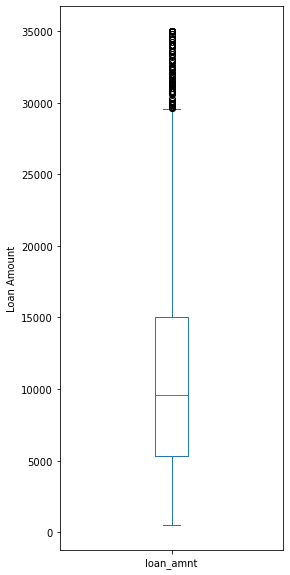

In [1177]:
plt.figure(figsize=[4,10])
plt.ylabel("Loan Amount")
loan_all.loan_amnt.plot.box()
plt.show()

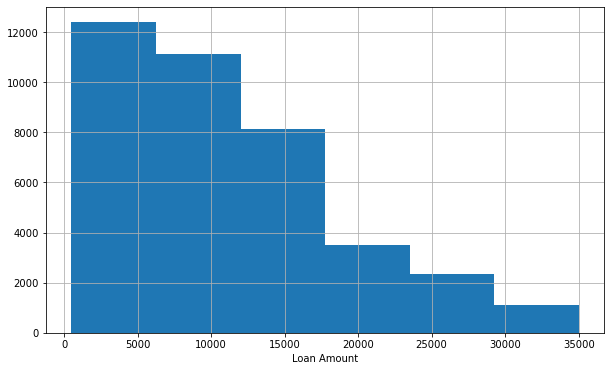

In [1178]:
plt.figure(figsize=[10,6])
plt.xlabel("Loan Amount")
loan_all.loan_amnt.hist(bins=6)
plt.show()

In [1179]:
def makeAmtGroups(x):
    if x<5000:
        return "0-5000"
    elif x<10000:
        return "5000-10000"
    elif x<15000:
        return "10000-15000"
    elif x<20000:
        return "15000-20000"
    elif x<25000:
        return "20000-25000"
    elif x>=25000:
        return ">25000"

# Make groups of int_rate.
loan_all['loan_amnt_category'] = loan_all.loan_amnt.apply(makeAmtGroups)
loan_all['loan_amnt_category'].value_counts()

5000-10000     12021
10000-15000     8654
0-5000          7444
15000-20000     4651
20000-25000     3045
>25000          2762
Name: loan_amnt_category, dtype: int64

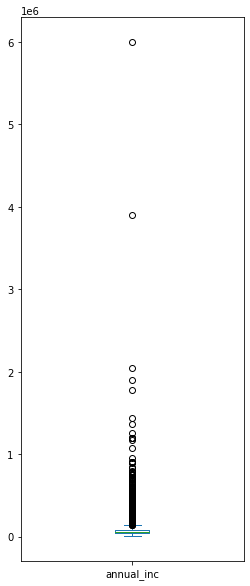

In [1180]:
plt.figure(figsize=[4,10])
loan_all.annual_inc.plot.box()
plt.show()

In [1181]:
# loan_all = loan_all.drop(columns=["annual_inc_int"], axis=1)

# Calculating IQR for annual_inc
q1 = loan_all.annual_inc.quantile(0.25)
q3 = loan_all.annual_inc.quantile(0.75)
iqr = q3-q1
print(q1)
print(q3)
print(iqr)

# Removing outlier from income Group
loan_all = loan_all[-(loan_all["annual_inc"]>((iqr*1.5)+q3))]
loan_all = loan_all[-(loan_all["annual_inc"]<(q1-(iqr*1.5)))]

40000.0
82000.0
42000.0


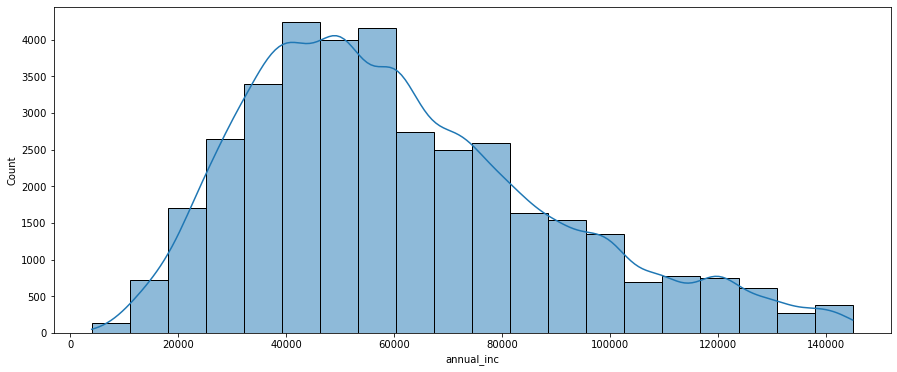

In [1183]:
plt.figure(figsize=[15,6])
# plt.xlabel("Annual Income")
sns.histplot(loan_all.annual_inc, bins=20, kde=True)
plt.show()

In [1184]:
def makeIncomeGroups(x):
    if x<25000:
        return "0-25000"
    elif x<50000:
        return "25000-50000"
    elif x<75000:
        return "50000-75000"
    elif x<100000:
        return "75000-100000"
    elif x<125000:
        return "100000-125000"
    elif x>=125000:
        return ">125000"

# Make groups of int_rate.
loan_all['annual_inc_category'] = loan_all.annual_inc.apply(makeIncomeGroups)
loan_all['annual_inc_category'].value_counts()

25000-50000      12057
50000-75000      11911
75000-100000      6327
100000-125000     2991
0-25000           2303
>125000           1226
Name: annual_inc_category, dtype: int64

In [1186]:
loan_all.shape

(36815, 44)

# 4. Univariate Analysis

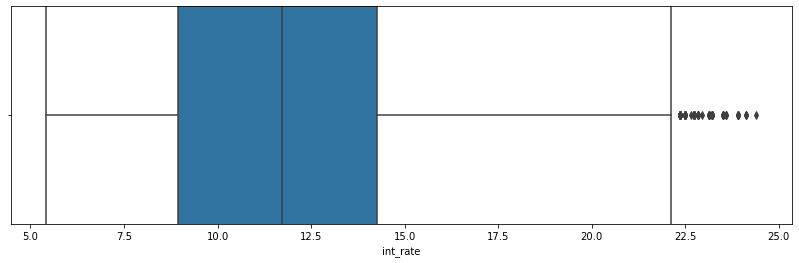

In [1191]:
plt.figure(figsize=[14,4])
sns.boxplot(x = 'int_rate', data = loan_all, width=8)
plt.show()

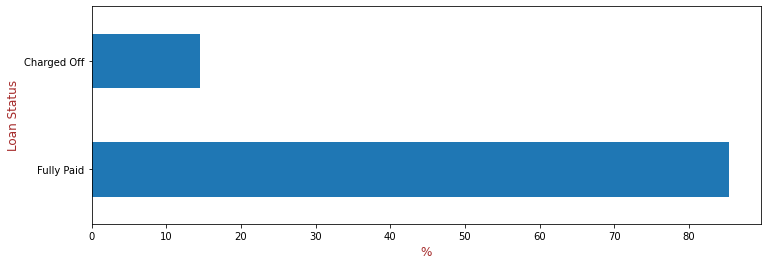

In [843]:
#Univariate analysis for Loan Status and percent of lons
loan_status_per = pd.Series(loan_all.loan_status.value_counts()).apply(
    lambda x: (x/loan_all.loan_status.value_counts().sum())*100)

plt.ylabel("Loan Status", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.xlabel("%", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
loan_status_per.plot(kind="barh", figsize=[12,4])
plt.xticks(rotation=0)
plt.show()


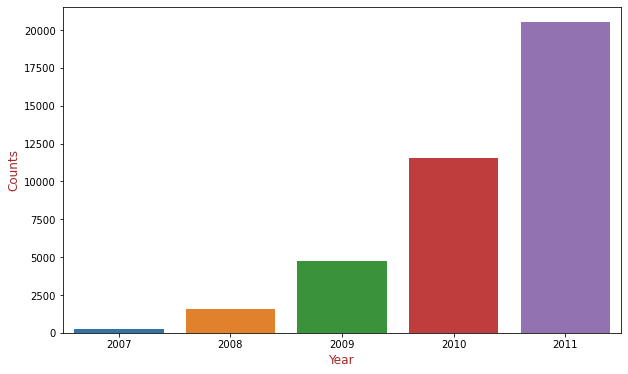

In [831]:
#Univariate analysis for Loan disbursed yearly
plt.figure(figsize=[10,6])
sns.countplot(x = 'issue_year', data=loan_all)
plt.xlabel("Year", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.ylabel("Counts", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
plt.show()

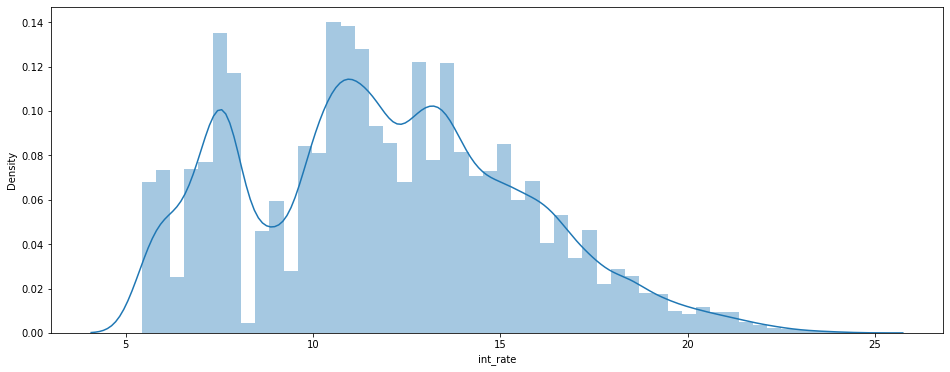

In [1205]:
#Univariate analysis for interest Rate
plt.figure(figsize=[16,6])
sns.distplot(loan_all.int_rate)
plt.show()

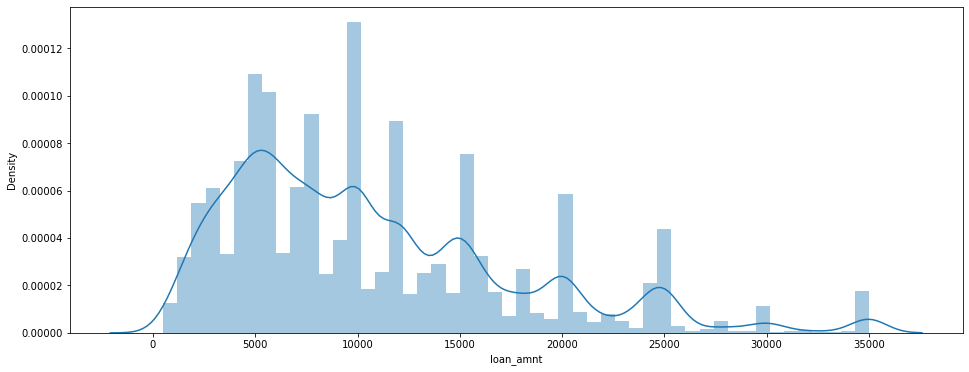

In [1207]:
#Univariate analysis for Loan Amount
plt.figure(figsize=[16,6])
sns.distplot(loan_all.loan_amnt)
plt.show()

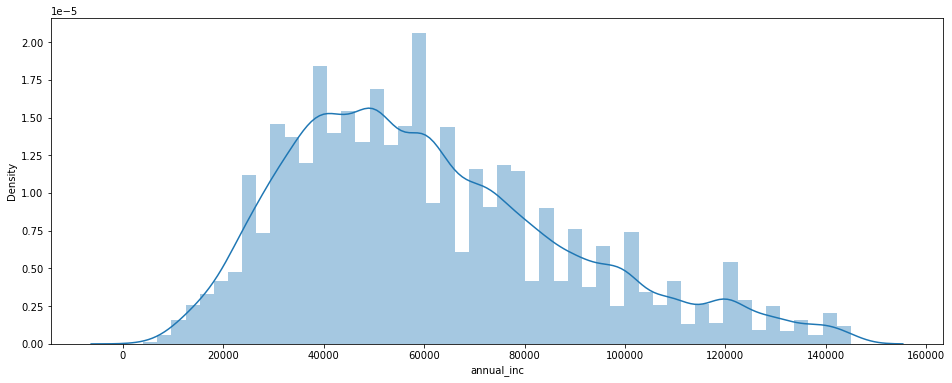

In [1209]:
#Univariate analysis for Annual income 
plt.figure(figsize=[16,6])
sns.distplot(loan_all.annual_inc)
plt.show()

# 5. Segmented Univariate Analysis

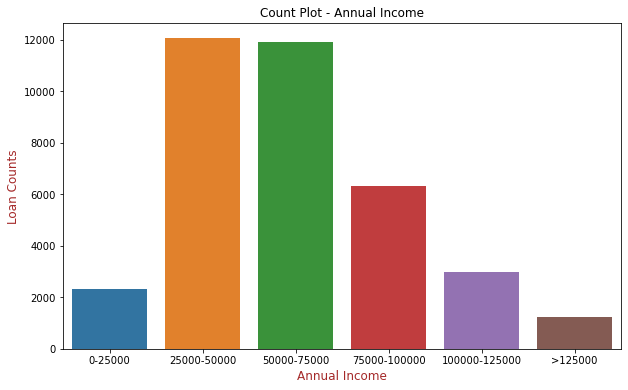

In [1200]:
# #Univariate analysis for Annual Income Ranges
#Create a count Plot of the Annual Income Ranges

plt.figure(figsize=[10,6])
sns.countplot(x = 'annual_inc_category', data=loan_all, 
              order = ["0-25000","25000-50000","50000-75000","75000-100000","100000-125000",">125000"])
plt.title('Count Plot - Annual Income')
plt.xlabel("Annual Income", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.ylabel("Loan Counts", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
plt.show()

# From the count plot below we can deduce that Annual income of customers that are taking loan is around 30k-80k range


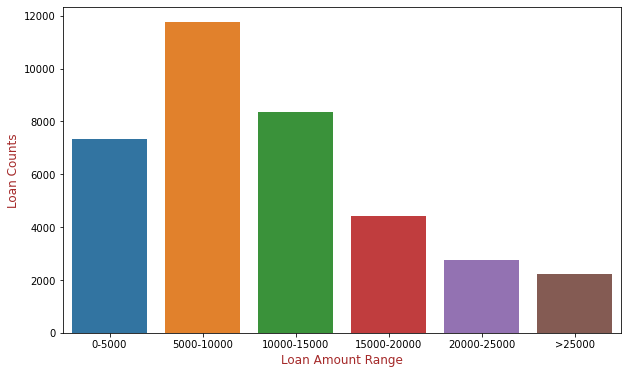

In [1198]:
#Univariate analysis for Loan Amount Ranges
plt.figure(figsize=[10,6])
sns.countplot(x = 'loan_amnt_category', data=loan_all, 
              order = ["0-5000", "5000-10000", "10000-15000", "15000-20000", "20000-25000", ">25000"])
plt.xlabel("Loan Amount Range", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.ylabel("Loan Counts", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
plt.show()

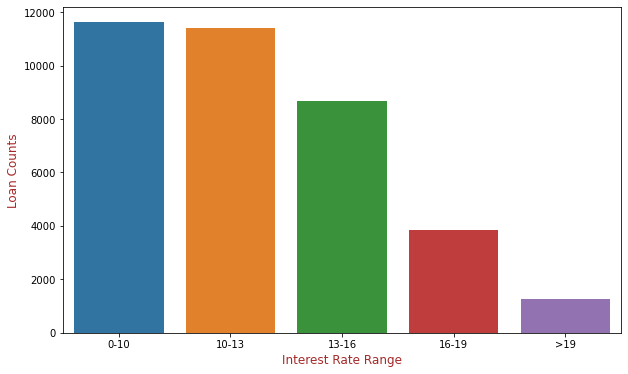

In [1199]:
#Univariate analysis for Interest Rate Ranges
plt.figure(figsize=[10,6])
sns.countplot(x = 'int_rate_category', data=loan_all, 
              order = ["0-10","10-13","13-16","16-19",">19"])
plt.xlabel("Interest Rate Range", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.ylabel("Loan Counts", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
plt.show()

# 6. Bivariate Analysis

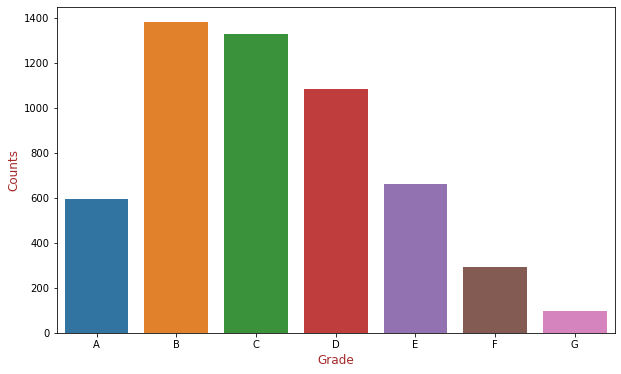

In [1210]:
#Bivariate analysis for Loan disbursed yearly
plt.figure(figsize=[10,6])
sns.countplot(x = 'grade', data = loan_all[loan_all.loan_status == 'Charged Off'], 
              order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.xlabel("Grade", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.ylabel("Counts", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
plt.show()

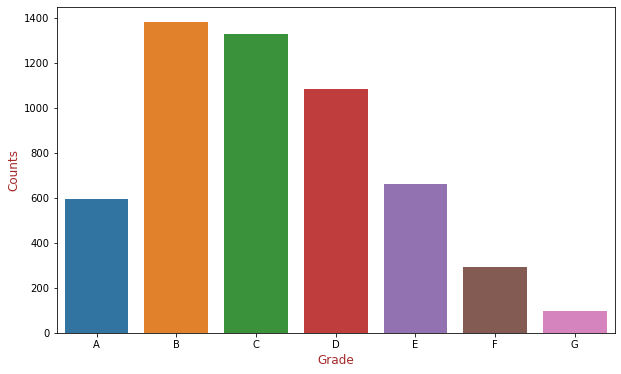

In [1212]:
#Bivariate analysis for Charged Off loan grade wise
plt.figure(figsize=[10,6])
sns.countplot(x = 'grade', data = loan_all[loan_all.loan_status == 'Charged Off'], 
              order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.xlabel("Grade", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.ylabel("Counts", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
plt.show()